In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [2]:
cases = pd.read_csv('./cases_uk.csv', parse_dates=['date'])
cases.set_index('date', inplace=True)
cases = cases[['newCasesBySpecimenDate']]

In [3]:
deaths = pd.read_csv('./deaths_uk.csv', parse_dates=['date'])
deaths.set_index('date', inplace=True)
deaths = deaths[['newDeaths28DaysByDeathDate']]

In [4]:
admissions = pd.read_csv('./admissions_uk.csv', parse_dates=['date'])
admissions.set_index('date', inplace=True)
admissions = admissions[['newAdmissions']]

# Cases - outcome relationships

In [5]:
combined = cases.join(other=deaths, how='inner')
combined = combined.join(other=admissions, how='inner')
combined.sort_index(inplace=True, ascending=True)

# Removed last 5 days (incomplete reporting)
# Not actually doing this because admissions data are missing for last few days
# combined = combined[:-5]

# Assert that there are no missing days
assert (combined.index.map(lambda t: t - timedelta(days=1))[1:] == combined.index[:-1]).all()

In [6]:
def get_peak_auto_corr(combined_df, outcome_name='newDeaths28DaysByDeathDate'):
    # Get autocorrelation function of deaths and cases
    max_days = 28
    
    start_date = datetime(2020, 9, 1)
    end_date = datetime(2021, 3, 1)
    combined_df = combined_df[(combined_df.index >= start_date) & (combined_df.index < end_date)]

    def get_corr_coeff(n_days):
        if n_days > 0:
            x = combined_df['newCasesBySpecimenDate'][:-n_days]
            y = combined_df[outcome_name][n_days:]
        else:
            x = combined_df['newCasesBySpecimenDate']
            y = combined_df[outcome_name]
        return np.corrcoef(x, y)[0, 1]

    auto_corr_fn = np.array([get_corr_coeff(d) for d in range(max_days)])
    argmax_d = np.argmax(auto_corr_fn)
    max_corr = np.max(auto_corr_fn)

    plt.plot(range(max_days), auto_corr_fn)

    print(f'Maximum correlation is {max_corr} at {argmax_d} days.')
    
    return argmax_d

Maximum correlation is 0.9076999273030384 at 14 days.


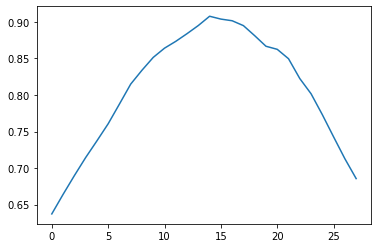

In [7]:
delay_days = get_peak_auto_corr(combined)

In [8]:
def plot_cases_outcome_relation(outcome_column_name: str,
                                outcome_name: str):
    delay_days = get_peak_auto_corr(combined, outcome_column_name)

    date_colors = [
        (datetime(2020, 1, 1), 'tab:blue', 'First wave'),
        (datetime(2020, 9, 1), 'tab:orange', 'Second wave'),
        (datetime(2020, 12, 3), 'tab:red', 'Third wave'),
        (datetime(2021, 4, 1), 'tab:green', 'Fourth wave'),
    ]

    date_ranges = list(zip([t[0] for t in date_colors], [t[0] for t in date_colors[1:]] + [datetime(2030, 1, 1)]))

    fig, ax = plt.subplots(figsize=(15, 10))

    for (_, c, l), (d1, d2) in zip(date_colors, date_ranges):
        idx_filt = (combined.index[:-delay_days] >= d1) & (combined.index[:-delay_days] < d2)

        ax.plot(
            combined['newCasesBySpecimenDate'][:-delay_days].iloc[idx_filt],
            combined[outcome_column_name][delay_days:].iloc[idx_filt],
            linestyle='none',
            marker='o',
            color=c,
            label=l
        )    

    ax.set_ylim(bottom=0)
    ax.set_xlabel(f'Cases per day (delayed by {delay_days} days)')
    ax.set_ylabel(f'{outcome_name} per day')
    ax.legend()

Maximum correlation is 0.9076999273030384 at 14 days.


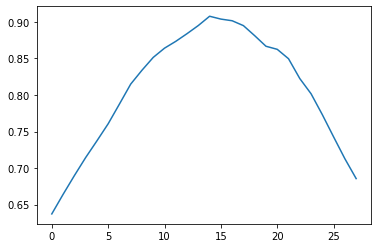

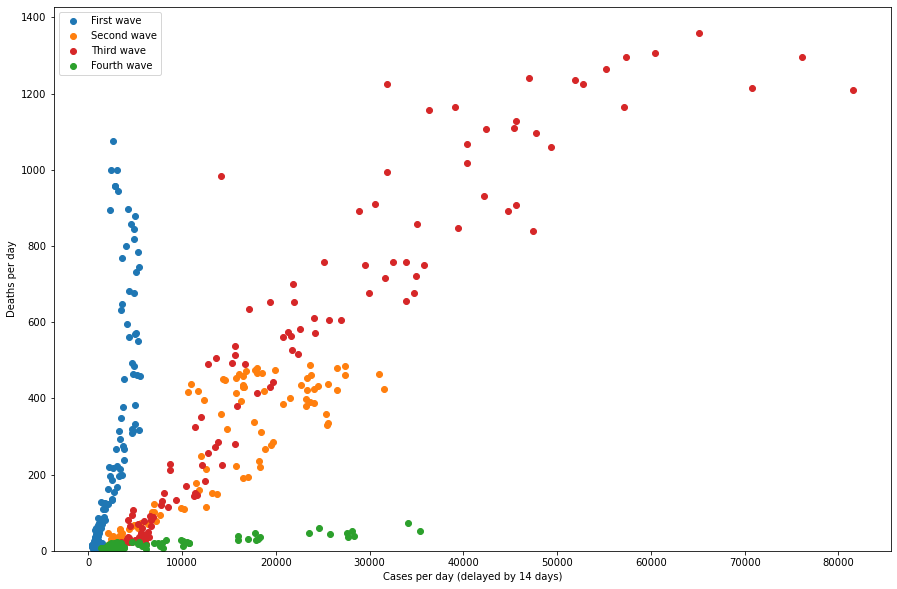

In [9]:
plot_cases_outcome_relation('newDeaths28DaysByDeathDate', 'Deaths')

Maximum correlation is 0.9181743248035711 at 7 days.


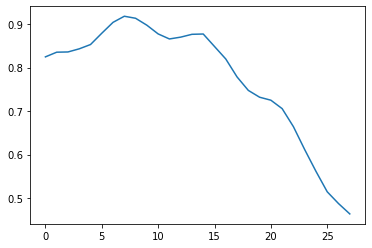

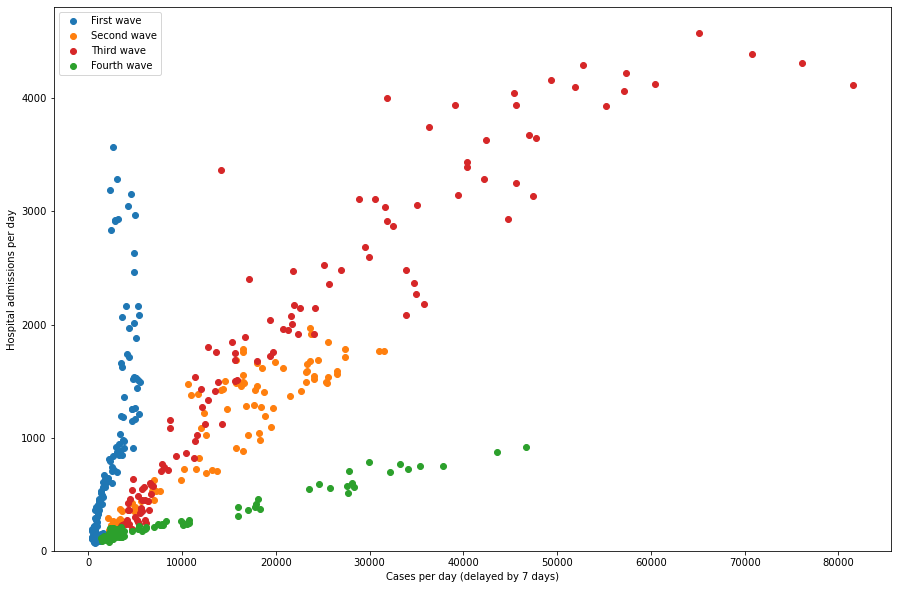

In [10]:
plot_cases_outcome_relation('newAdmissions', 'Hospital admissions')